# CL Paper plot Figures

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, time, re, shutil, random
from pathlib import Path
from datetime import datetime
from glob import glob
import collections

from sklearn.model_selection import train_test_split
from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage.io import imread_collection
from scipy.io import loadmat
from tqdm.notebook import tqdm
# from tqdm.auto import tqdm

import torch
from torchinfo import summary
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Subset
import torchvision.transforms as T
# import albumentations as A
from torchvision.transforms import Lambda, Compose, PILToTensor, ToTensor
# !pip install visdom
# import visdom # creating, organizing, and sharing visualizations of live, rich data.

from IPython.display import clear_output

import cv2     # for capturing videos
import math    # for mathematical operations
# from skimage.transform import resize
# import natsort

# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()

sys.path.append('/home/muhammada/PDRA/works/cc_models/')
sys.path.append('/home/muhammada/PDRA/works/utils/')

''' SEED Everything '''
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True 
seed=42
seed_everything(seed=seed)

print("Using torch", torch.__version__) # colab= 1.10.0+cu111

Using torch 1.10.2


C:\Users\muhammada\Anaconda3\envs\PyTorch\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\muhammada\Anaconda3\envs\PyTorch\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


## Load Data

In [15]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from cc_load_data import load_data


i = 2
ds_names   = ['Mall', 'ShanghaiTechPartA', 'ShanghaiTechPartB', 'DroneRGBT', 'CARPK', 'UCSD', 'UCF_CC_50']
ds_name    = ds_names[i]
drive      = '/home/muhammada'         
root_dir   = drive + '/PDRA/works/cc_datasets/' + ds_names[i]
train_img_paths, train_gt_paths, val_img_paths, val_gt_paths, test_img_paths, test_gt_paths = load_data(root_dir=root_dir, ds_name=ds_name)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

>>>>>>>> ShanghaiTechPartB Dataset is successfuly loaded .. 😀

Train data (img/gt)   :  400 = 400
Test data (img/gt)    :  316 = 316
Total data (img/gt)   :  716 = 716


## Sort Data

In [16]:
from sort_data import sort_data_bycount

### Method 1:  using actual count
### Arrange train paths and set "Shuffle=False" in train_daataloader.
count, train_img_paths, train_gt_paths = sort_data_bycount(train_img_paths, train_gt_paths, ds_name)
print(len(count))

### Method 2:  using counting errors (pretrained model: CSRNet).



400


## Create Dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Image displayed .. 😎
img => torch.Size([3, 768, 1024]) gt => torch.Size([1, 96, 128]), count => 0


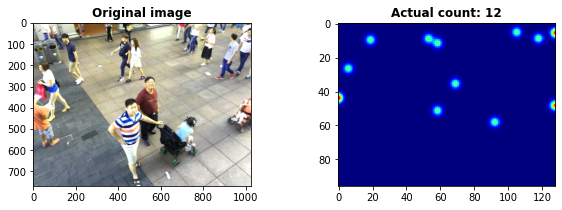

In [17]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# from dataset.DroneDataset import DroneDataset
from CrowdDataset import CrowdDataset # CrowdDataset2 uses image resizing
# from CrowdDatasetP import CrowdDatasetTrain, CrowdDatasetTest


## For dataset of same size
img_downsample = 1
gt_downsample  = 8 ## This is the model output size as compared to input
sigma     = 15
train_ds  =  CrowdDataset(train_img_paths, train_gt_paths, img_downsample, gt_downsample, ds_name, sigma=sigma, augmentation=True)  # img_size, gt_size = None for arbitrary shapes
val_ds    =  CrowdDataset(val_img_paths, val_gt_paths, img_downsample, gt_downsample, ds_name, sigma=sigma, augmentation=False)  # img_size, gt_size = None for arbitrary shapes
test_ds   =  CrowdDataset(test_img_paths, test_gt_paths, img_downsample, gt_downsample, ds_name, sigma=sigma, augmentation=False)  # img_size, gt_size = None for arbitrary shapes

## For dataset of different size images
# img_size = (768, 1024, 3)
# ds       = 4 # CSRNet=8, CANNet=8, MCNN=4, LCDnet2=2, SANET=1
# gt_size  = (int(img_size[0]/ds), int(img_size[1]/ds))  # (3,192,256)
# sigma    = 10
# train_ds  =  CrowdDataset2(train_img_paths, train_gt_paths, img_size, gt_size, ds_name, sigma=sigma, augmentation=True)  # img_size, gt_size = None for arbitrary shapes
# val_ds    =  CrowdDataset2(val_img_paths, val_gt_paths, img_size, gt_size, ds_name, sigma=sigma, augmentation=False)  # img_size, gt_size = None for arbitrary shapes
# test_ds   =  CrowdDataset2(test_img_paths, test_gt_paths, img_size, gt_size, ds_name, sigma=sigma, augmentation=False)  # img_size, gt_size = None for arbitrary shapes

#### Dataloaders
batch_size = 8
train_dl  = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=False) # pre_load=True
val_dl    = torch.utils.data.DataLoader(val_ds,   batch_size=1, num_workers=2, pin_memory=True, shuffle=False)
test_dl   = torch.utils.data.DataLoader(test_ds,  batch_size=1, num_workers=2, pin_memory=True, shuffle=False)


## Run
from cc_utils import display_sample
i = 0
img, gt, c = train_dl.dataset[i]
fig = display_sample(img, gt)
print(f'img => {img.shape} gt => {gt.shape}, count => {c}')


## Plot Pacing Function

In [6]:
# ###########  CL Set up
from get_pacing_function import get_pacing_function


def plot_pacing_function(train_ds, pacing_f, a, b, batch_size):
    ''' Plot pacing function '''
    iterations = []
    data       = []
    
    ###########  CL Set up
    n_epochs        = 1
    N               = len(train_ds)
    iter_per_epoch  = N//batch_size  
    M               = iter_per_epoch # 32  # No. of samples to feed to the model in each iterations (256)
    n_iterations    = (N//batch_size+1)*n_epochs
    print(pacing_f,' ==> n_iterations', n_iterations)
    all_sum         = N/(n_iterations*(n_iterations+1)/2)
    pre_iterations  = 0
    startIter       = 0
    pacing_function = get_pacing_function(n_iterations, N, a, b, pacing_f)
    startIter_next  = pacing_function(0) # <=======================================
    
    
    order     = np.arange(0, len(train_ds))
    # print(f' M {M}, startIter {startIter}, startIter_next {startIter_next}')
    
    train_dss = Subset(train_ds, list(order[startIter:max(startIter_next, M)])) #  max => min
    train_dls = torch.utils.data.DataLoader(train_dss, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True) 
    dataiter  = iter(train_dls)
    step      = 0
    
    ## Start training
    # print (f'1: iter data between {startIter} and {startIter_next} with Pacing => {pacing_f}')
    for step in range(1, n_iterations+1):
        # print(f"Step {step} of {n_iterations}")
        # print('Loading samples', len(train_dss))
        step += 1
        pre_iterations = step 
        
        if startIter_next <= N:            
            startIter_next = pacing_function(step)# <=======================================
            # print ("%s iter data between %s and %s w/ Pacing %s and LEARNING RATE %s "%(step, startIter, startIter_next, pacing_f, optimizer))
            # print (f'{step}: iter data between {startIter} and {startIter_next} with Pacing => {pacing_f}')
            train_dss  = Subset(train_ds, list(order[startIter:max(startIter_next, M)])) # max => min
            train_dls  = torch.utils.data.DataLoader(train_dss, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        
        iterations.append(step)
        data.append(len(train_dss))
       
        if step == n_iterations:
            print('Training completed .. \n')
    return iterations, data

functions = ['linear', 'quad', 'exp', 'log', 'root', 'step']

steps_arr = []
data_arr  = []
for i,f in enumerate(functions):
    print(f'Using {f}')
    steps, data  = plot_pacing_function(train_ds, pacing_f=f, a=0.5, b=0.1, batch_size=8)
    steps_arr.append(steps)
    data_arr.append(data)
    
# steps, data = plot_pacing_function(train_ds, pacing_f='linear', a=0.5, b=0.8, batch_size=8)
    

Using linear
linear  ==> n_iterations 51
Training completed .. 

Using quad
quad  ==> n_iterations 51
Training completed .. 

Using exp
exp  ==> n_iterations 51
Training completed .. 

Using log
log  ==> n_iterations 51
Training completed .. 

Using root
root  ==> n_iterations 51
Training completed .. 

Using step
step  ==> n_iterations 51
Training completed .. 



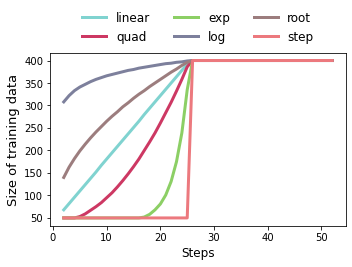

In [26]:
### Plot pacing function
functions = ['linear', 'quad', 'exp', 'log', 'root', 'step']
c = ['k', 'r', 'g', 'y', 'b', 'm']
c = ['#80D3D0','#CD3863',  '#8CCF65', '#7D809C', '#9C7D7E', '#EC797E']

# steps, data = plot_pacing_function(train_ds, pacing_f='linear', a=1.0, b=0.0, batch_size=8)
fig, ax = plt.subplots(1,1, figsize=(5,4))
for i,f in enumerate(functions):
    # steps, data = plot_pacing_function(train_ds, pacing_f=f, a=0.9, b=0.0, batch_size=8)
    # ax.plot(steps, data, ls='-', lw=2, color=c[i], label=f)
    ax.plot(steps_arr[i], data_arr[i], ls='-', lw=3, color=c[i], label=f)
ax.set_xlabel('Steps', fontsize=12)
ax.set_ylabel('Size of training data', fontsize=13)
ax.legend(loc=9, bbox_to_anchor=(0.5, 1.3), ncol=3, fontsize=12, frameon=False)
plt.tight_layout()
plt.savefig('pacing_function.pdf', dpi=300)


quad  ==> n_iterations 51
Training completed .. 

quad  ==> n_iterations 51
Training completed .. 

quad  ==> n_iterations 51
Training completed .. 

quad  ==> n_iterations 51
Training completed .. 



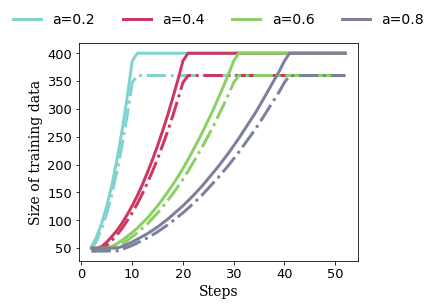

In [22]:

# a => fraction of data needed for the pacing function to reach the size of full train set.
# b => fraction of training set used at start of training.

a  = [0.2, 0.4, 0.6, 0.8]
b  = [0.1, 0.2, 0.2, 0.4, 0.8]
c = ['#80D3D0','#CD3863',  '#8CCF65', '#7D809C']
ls = ['-', '--', '-.', ':']

f = 1 # linear
epsilon = 0.90
steps_arr = []
data_arr  = []
data_arr2  = []
for i in range(0, len(a)):
    steps, data  = plot_pacing_function(train_ds, pacing_f=functions[f], a=a[i], b=0.1, batch_size=8)
    data2        = [x*epsilon for x in data]
    steps_arr.append(steps)
    data_arr.append(data)
    data_arr2.append(data2)

fig, ax = plt.subplots(1,1, figsize=(5,4))
for i in range(0, len(a)):
    ax.plot(steps_arr[i], data_arr[i], ls='-', lw=3, color=c[i], label=f'a={a[i]}')
    ax.plot(steps_arr[i], data_arr2[i], ls='-.', lw=3, color=c[i])
ax.set_xlabel('Steps', fontsize=14, fontname='serif')
ax.set_ylabel('Size of training data', fontsize=14, fontname='serif')
ax.tick_params(axis='both', which='major', labelsize=13)
ax.tick_params(axis='both', which='minor', labelsize=13)
ax.legend(loc=9, bbox_to_anchor=(0.5, 1.2), ncol=4, fontsize=14, frameon=False)
plt.savefig(f'pacing_{functions[f]}_epsilon.pdf', dpi=150, bbox_inches='tight')

## Plot Results

In [ ]:
MCNN

### ShanghaiTech Part B

In [183]:
functions = ['without CL', 'linear', 'quad', 'exp', 'log', 'root', 'step']
models   = ['MCNN', 'CMTL', 'CSRNet']
mcnn     = [26.4, 19, 18.5, 18.2, 19.3, 18.5, 20]
cmtl     = [20, 19, 18, 17, 16, 15, 14]
csrnet   = [11, 10, 9, 8, 7, 7, 6]
x       =  [1,2,3,4,5,6,7]
df       = pd.DataFrame(index=models, columns=functions, data=[mcnn, cmtl, csrnet])
df2     = df.T
df2['Index'] = df2.index
df2



,MCNN,CMTL,CSRNet,Index
without CL,26.4,20.0,11.0,without CL
linear,19.0,19.0,10.0,linear
quad,18.5,18.0,9.0,quad
exp,18.2,17.0,8.0,exp
log,19.3,16.0,7.0,log
root,18.5,15.0,7.0,root
step,20.0,14.0,6.0,step


<AxesSubplot:ylabel='Index'>

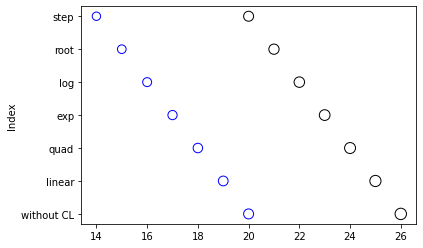

In [150]:

ax = df2.plot.scatter(y='Index', x='MCNN', s=[x*5 for x in mcnn], c='w', ec='k')
df2.plot.scatter(y='Index', x='CMTL', s=[x*5 for x in cmtl], c='w', ec='b', ax=ax, xlabel='')

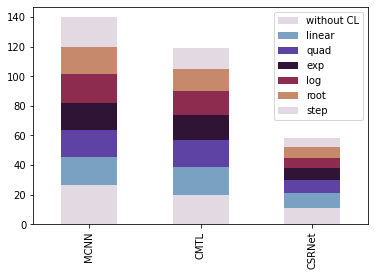

In [201]:

### Line Plot
# fig, ax = plt.subplots(1,1, figsize=(5,4))
# ax2 = ax.twinx()
# c  = ['#110033', '#4c00e6', '#661aff', '#884dff', '#aa80ff', '#ccb3ff', '#ddccff']
# ax2.scatter([i*1 for i in x], mcnn,  marker='o', c=c, ec='k',s=[x*5 for x in cmtl], alpha=0.9) # hot cool twilightht
# ax2.scatter([i*2 for i in x], cmtl,  marker='D', c=c, ec='k', s=[x*5 for x in cmtl], alpha=0.9) # hot cool twilightht
# ax2.scatter([i*3 for i in x], csrnet, marker='v', c=c, ec='k', s=[x*5 for x in cmtl], alpha=0.9) # hot cool twilightht
# ax.grid(alpha=0.9, zorder=0, lw=0.4)


### Bar plot
ax.grid(alpha=0.9, zorder=0, lw=0.4)
ax = df.plot.bar(stacked=True, colormap='twilight', alpha=1) # hot cool twilight
# ax = df.plot(colormap='twilight', alpha=1) # hot cool twilight



# ax.set_xlabel('Steps', fontsize=14, fontname='serif')
# ax.set_ylabel('Size of training data', fontsize=14, fontname='serif')
# ax.tick_params(axis='both', which='major', labelsize=13)
# ax.tick_params(axis='both', which='minor', labelsize=13)
# ax.legend(loc=9, bbox_to_anchor=(0.5, 1.2), ncol=4, fontsize=14, frameon=False)
# plt.savefig(f'accuracy_STB.pdf', dpi